In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN

In [3]:
data = pd.read_csv('OnlineRetail3.csv', encoding='unicode_escape')

## Data Preprocessing

### Initial Data Description

In [4]:
#How big is the data?
data.shape

(541909, 8)

In [5]:
#How does the data look like?
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [6]:
data.sample(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
77301,542719,22217,T-LIGHT HOLDER HANGING LACE,2,1/31/2011 14:18,1.25,17619.0,United Kingdom
332441,566073,47566,PARTY BUNTING,4,9/8/2011 19:58,4.95,14562.0,United Kingdom
175690,551982,22440,BALLOON WATER BOMB PACK OF 35,6,5/5/2011 13:56,0.42,15023.0,United Kingdom
299045,563076,22336,DOVE DECORATION PAINTED ZINC,288,8/11/2011 16:12,0.55,14646.0,Netherlands
315847,564735,22026,BANQUET BIRTHDAY CARD,12,8/28/2011 13:35,0.42,15856.0,United Kingdom


In [7]:
#What is the data type of the columns?
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [8]:
#Are there any missing (null) values?
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
#Are there any duplicate values?
data.duplicated().sum()

5268

### Null value imputation

As we saw above, there are 1454 missing values in Description column and 135080 missing values in CustomerID column. But since
our project is based on Customer Segmentation, we need CustomerID values and it cannot be imputed. We are, thus, going 
to remove null values in CustomerID field.

In [12]:
data.dropna(inplace=True)

In [13]:
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [14]:
data.shape

(406829, 8)

### Feature Engineering

We will create a total amount feature to indicate the total amount spent by the customer at each purchase

In [23]:
#Total Amount Feature
data['Total_Amount'] = data['Quantity']*data['UnitPrice']

We are going to be using RFM technique for analysis of data. It consists of three terms:
- Recency: Indicating the number of unit time passed since the last purchase (days)
- Frequency: Indicating the frequency of purchase
- Monetary: Indicating the amount spent on the purchase

This new RFM dataframe will be our working dataset for customer segmentation and analytics (based on the primary dataset)

In [24]:
#Monetary
m = data.groupby('CustomerID')['Total_Amount'].sum()
m = pd.DataFrame(m).reset_index()

In [25]:
m.head()

,CustomerID,Total_Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [26]:
#Frequency
f = data.groupby('CustomerID')['InvoiceNo'].count()
f = f.reset_index()
f.columns = ['CustomerID', 'Frequency']

In [27]:
f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [32]:
#Recency
#Part 1
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'], format="%m/%d/%Y %H:%M")

#Extracting the difference between the maximum date of purchase and last date of purchase
last_day = max(data['InvoiceDate'])
data['difference'] = last_day - data['InvoiceDate']

In [29]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Total_Amount,difference
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,373 days 04:24:00
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,373 days 04:24:00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,373 days 04:24:00


As we can see that the difference column has the values in terms of a timestamp. We, on the other hand, are only interested in
number of days passed since the last purchase for our calculation of recency. Therefore, we shall now create a function to 
remove all the other information and only reserve the number of days for ourselves

In [37]:
def get_Days(x):
    y = str(x).split()[0]
    return int(y)

In [39]:
data['difference'] = data['difference'].apply(get_Days)

In [41]:
#Part 2
r = data.groupby('CustomerID')['difference'].min()
r = r.reset_index()
r.columns = ['CustomerID', 'Recency']

In [42]:
r.head()

,CustomerID,Recency
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


We shall now merge the three individual dataframes (m, f, r) into one single dataframe

In [43]:
#Merge
group_df = pd.merge(m, f, on='CustomerID', how='inner')
RFM_data = pd.merge(group_df, r, on='CustomerID', how='inner')
RFM_data.columns = ['CustomerID', 'Monetary', 'Frequency', 'Recency']

In [44]:
RFM_data.head()

,CustomerID,Monetary,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


This new dataframe created is called RFM_data and would be our working dataframe for customer segmentation

## Exploratory Data Analysis and Outlier Imputation

### EDA

In [45]:
data['Country'].value_counts()

United Kingdom          361878
Germany                   9495
France                    8491
EIRE                      7485
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1877
Portugal                  1480
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
USA                        291
Israel                     250
Unspecified                244
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


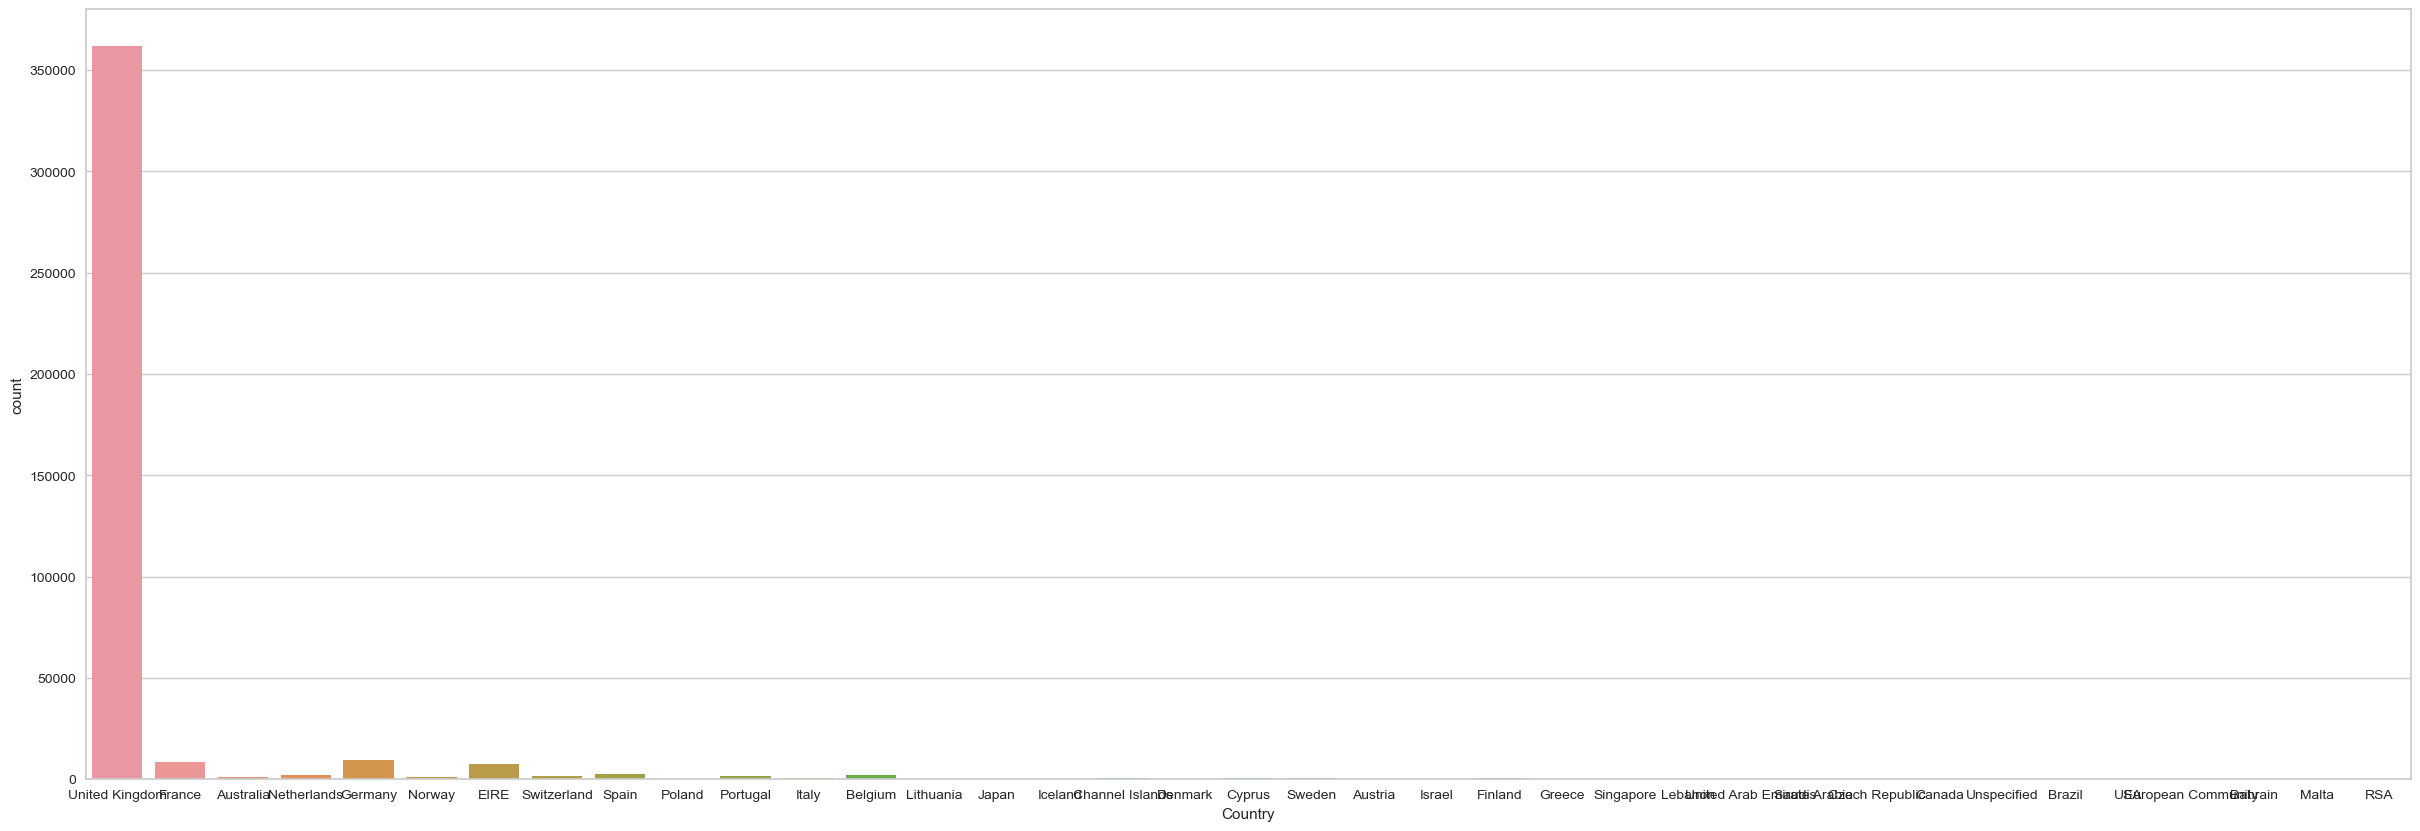

In [78]:
plt.figure(figsize=(30,10))
plt.xlabel('Country')
sns.countplot(data['Country'])
plt.show()

As we can see, the number of purchases from United Kingdom dominates other countries

<AxesSubplot:xlabel='Quantity', ylabel='Count'>

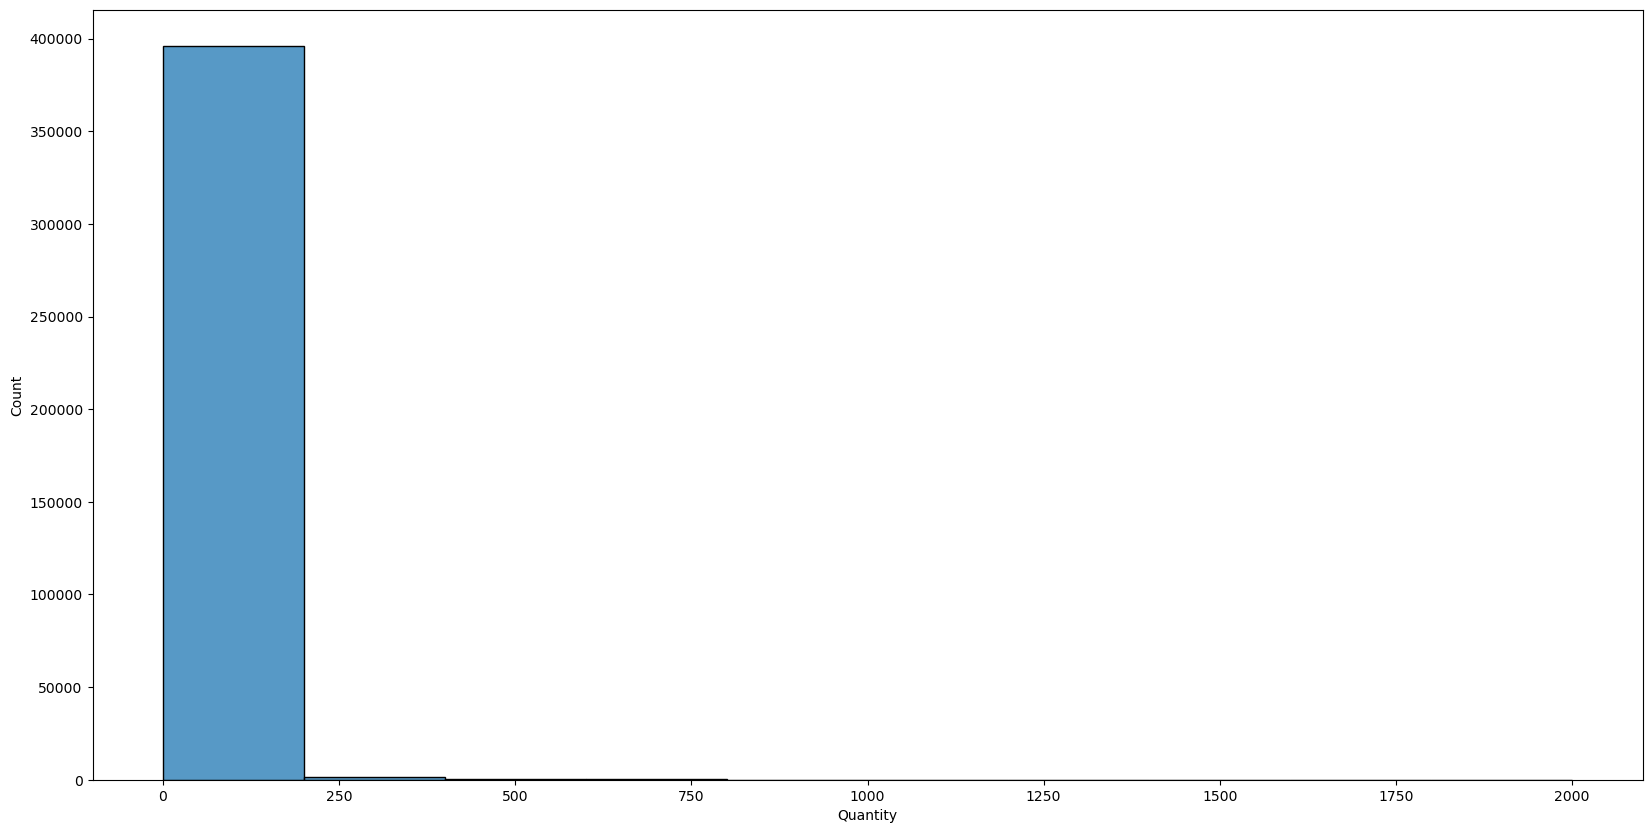

In [56]:
plt.figure(figsize=(20,10))
sns.histplot(data['Quantity'], bins=10, binrange=(0,2000))

As we can see, most frequency of purchases made by individual customers fall between 0 and 250 product units, which (frequency) is almost 40k for some units

Let's look at RFM_data 

<AxesSubplot:xlabel='Recency', ylabel='Count'>

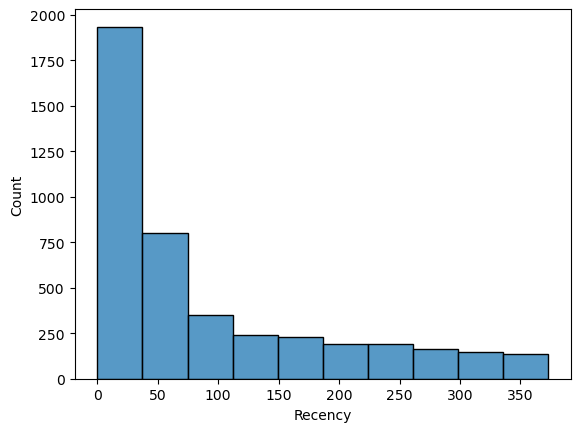

In [57]:
sns.histplot(RFM_data['Recency'], bins=10)

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Recency'>

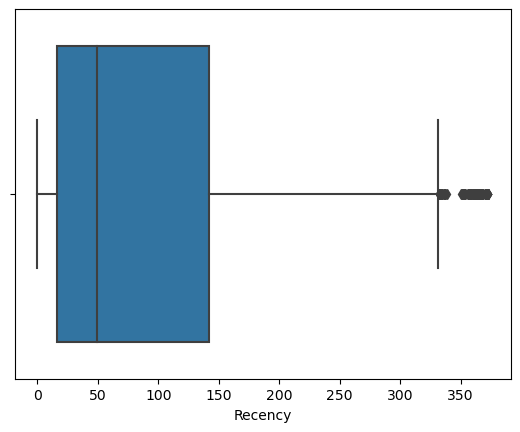

In [58]:
sns.boxplot(RFM_data['Recency'])

The Recency feature is not only right skewed but also shows presence of outliers. The recency plot also shows that the most recency of purchases is between 0 and 50 days. It can be inferred that the most recent purchases has been within less than 50 days of the maximum date

<AxesSubplot:xlabel='Frequency', ylabel='Count'>

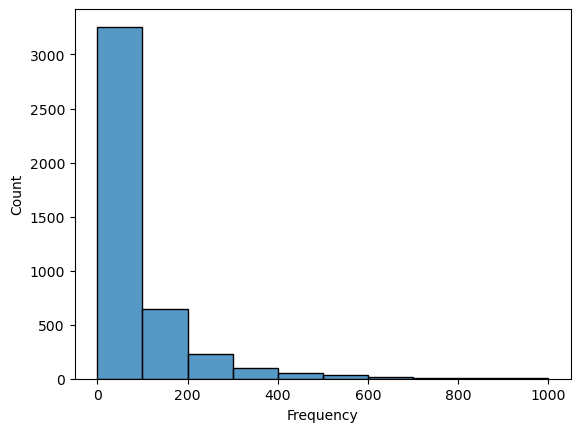

In [60]:
sns.histplot(RFM_data['Frequency'], bins=10, binrange=(0,1000))

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Frequency'>

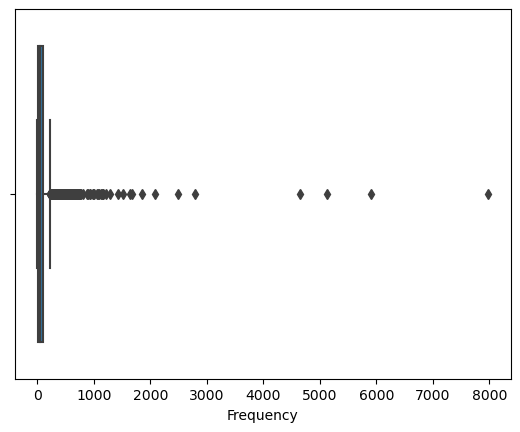

In [61]:
sns.boxplot(RFM_data['Frequency'])

The Frequency feature is extremely right skewed and shows the presence of outliers.

<AxesSubplot:xlabel='Monetary', ylabel='Count'>

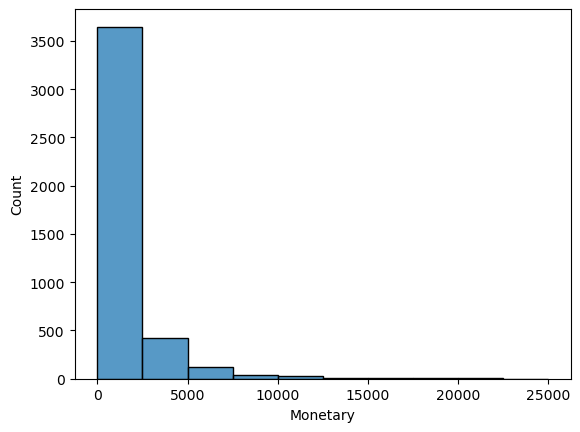

In [63]:
sns.histplot(RFM_data['Monetary'], bins=10, binrange=(0, 25000))

The maximum count of amount expended on purchase is between 0 and 2500.

C:\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Monetary'>

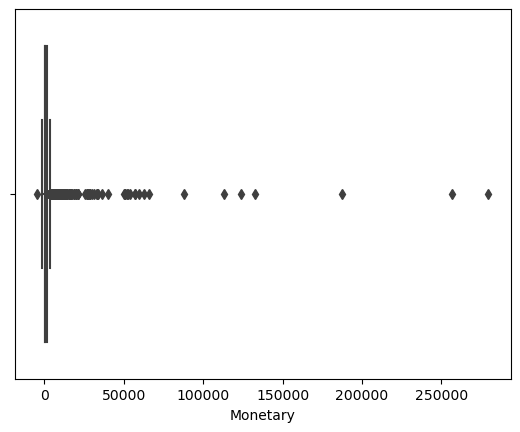

In [64]:
sns.boxplot(RFM_data['Monetary'])

The Monetary feature is extremely right skewed and shows the presence of outliers.

In [65]:
RFM_data.describe()

,CustomerID,Monetary,Frequency,Recency
count,4372.000000,4372.000000,4372.000000,4372.000000
mean,15299.677722,1898.459701,93.053294,91.047118
std,1722.390705,8219.345141,232.471608,100.765435
min,12346.000000,-4287.630000,1.000000,0.000000
25%,13812.750000,293.362500,17.000000,16.000000
50%,15300.500000,648.075000,42.000000,49.000000
75%,16778.250000,1611.725000,102.000000,142.000000
max,18287.000000,279489.020000,7983.000000,373.000000


### Outlier removal

In [67]:
outlier_vals = ['Monetary', 'Frequency', 'Recency']

for column in outlier_vals:
    low_quant = RFM_data[column].quantile(0.25)
    high_quant = RFM_data[column].quantile(0.75)
    iqr = high_quant - low_quant
    low_BV = low_quant - 1.5*iqr
    high_BV = high_quant + 1.5*iqr
    
    outliers = RFM_data[(RFM_data[column] < low_BV) | (RFM_data[column] > high_BV)].index
    print(f'{len(outliers)} outliers detected in column {column}')
    
    RFM_data.drop(outliers, inplace=True)

423 outliers detected in column Monetary
252 outliers detected in column Frequency
0 outliers detected in column Recency


In [68]:
RFM_data.describe()

,CustomerID,Monetary,Frequency,Recency
count,3697.000000,3697.000000,3697.000000,3697.000000
mean,15307.517176,771.363098,46.658101,103.272383
std,1717.432301,740.646223,41.705211,103.798588
min,12346.000000,-1592.490000,1.000000,0.000000
25%,13822.000000,248.100000,15.000000,22.000000
50%,15308.000000,508.460000,32.000000,60.000000
75%,16784.000000,1046.560000,68.000000,169.000000
max,18287.000000,3563.850000,178.000000,373.000000


## Standardization

In [69]:
scaled_df = RFM_data[['Monetary', 'Frequency', 'Recency']]
scaler = StandardScaler()

rfm_df_scaled = scaler.fit_transform(scaled_df)

rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Monetary', 'Frequency', 'Recency']

## Assumptions

## Model

We will be choosing K-Means clustering model for this problem since this problem is a problem of unsupervised learning

### Within Cluster Sum of Square and Elbow method

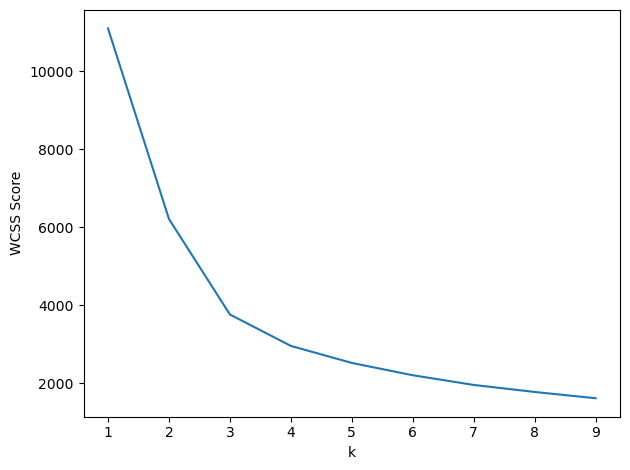

In [70]:
k_values = list(range(1,10))
wcss_list = []

for k in k_values:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit_transform(rfm_df_scaled)
    wcss_list.append(kmeans.inertia_)
    
plt.plot(k_values, wcss_list)
plt.xlabel('k')
plt.ylabel('WCSS Score')
plt.tight_layout()
plt.show()

From the graph we can see that at k=3, graph has an elbow

In [71]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(rfm_df_scaled)

KMeans(n_clusters=3)

## 3-D plot of Clusters

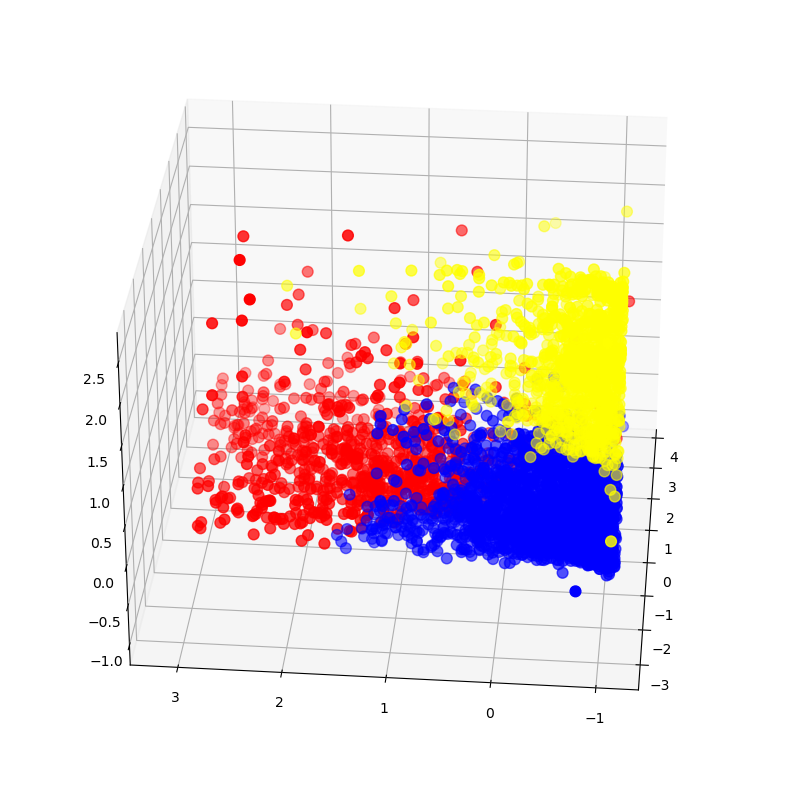

In [72]:
clusters = kmeans.labels_
RFM = rfm_df_scaled 
RFM['labels'] = clusters
fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(RFM["Monetary"][RFM.labels == 0], RFM["Frequency"][RFM.labels == 0], RFM["Recency"][RFM.labels == 0], c='blue', s=60)
ax.scatter(RFM["Monetary"][RFM.labels == 1],RFM["Frequency"][RFM.labels == 1], RFM["Recency"][RFM.labels == 1], c='red', s=60)
ax.scatter(RFM["Monetary"][RFM.labels == 2], RFM["Frequency"][RFM.labels == 2], RFM["Recency"][RFM.labels == 2], c='yellow', s=60)
ax.view_init(30, 185)
plt.show()

## Evaluation using Silhouette Method

We will use silhouette method to evaluate the model. We will implement it using the Yellowbrick library

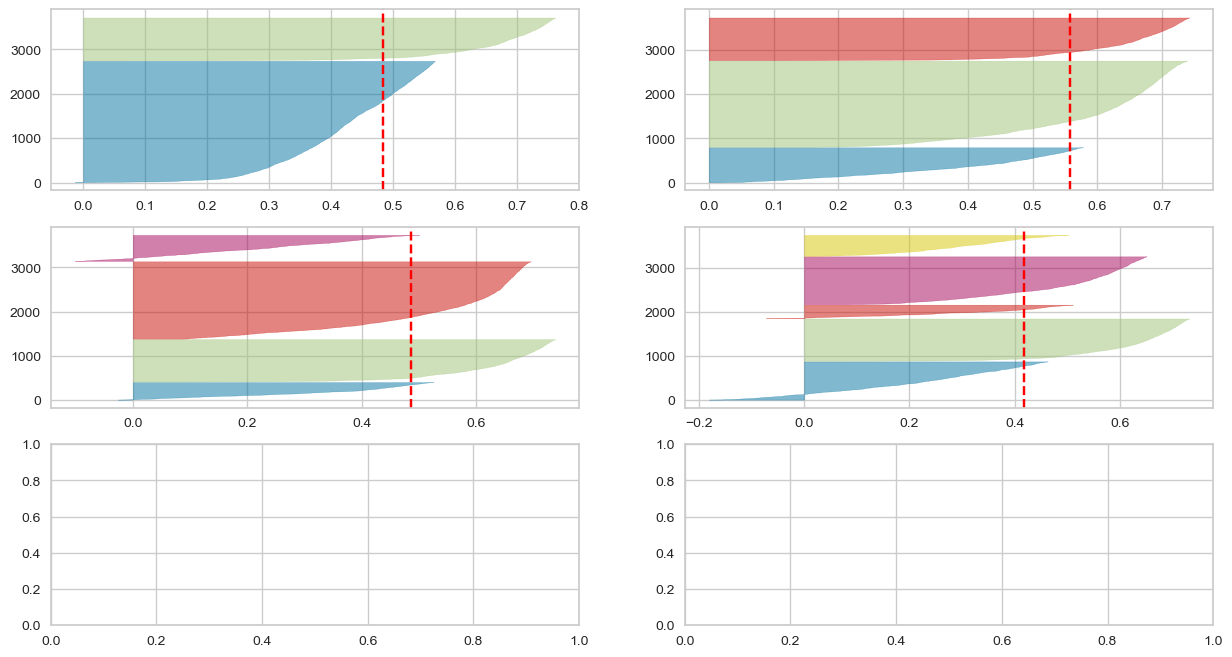

In [77]:
from yellowbrick.cluster import SilhouetteVisualizer
fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instances for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, 
                max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', 
                                      ax=ax[q-1][mod])
    visualizer.fit(rfm_df_scaled)
    

The graph shows that K=2 has the maximum score
There are two conditions for silhouette score to work:
    1. The silhouette score should be more than the average score
    2. There should not be wide fluctuations in the score graph
    
Going by this we can safely choose K=3, as it is the least wide in the final graph